In [1]:
from bs4 import BeautifulSoup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rq
import seaborn as sns
import re
sns.set_context('notebook')

In [2]:
def getParamsRequestValue(i_reportmodel_num, i_reportmodel_xsl_num, section, year, semester): 
    r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter', params={'ww_i_reportmodel' : i_reportmodel_num})
    parameters_map = { 'ww_x_UNITE_ACAD' : section, 'ww_x_PERIODE_ACAD' : year, 'ww_x_PERIODE_PEDAGO' : semester }
    
    soup = BeautifulSoup(r.text, 'html.parser')
    
    ps = {key: next((option.attrs['value'] for option in soup.find('select', {'name': key }) if option.text==value), None) for key, value in parameters_map.items()}
    o = {'ww_i_reportmodel' : i_reportmodel_num, 'ww_b_list' : 1, 'ww_i_reportModelXsl' : i_reportmodel_xsl_num, 'ww_x_HIVERETE' : 'null', 'dummy' : 'ok'}
    d = {**o, **ps}
    r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter', params=d)
    soup = BeautifulSoup(r.text, 'html.parser')
    for p in soup.find_all('a'):
        if(p.text==', '.join([section, year, semester])):
            arr = re.search('\(\'(.+?)\'\)', p['onclick']).group(1).split("=")
            d[arr[0]] = int(arr[1])
                  
    return d

In [3]:
ww_i_reportmodel_num=133685247
ww_i_reportModelXsl_num=133685270
section = 'Informatique'
master_semesters = ['Master semestre 1', 'Master semestre 2', 'Master semestre 3', 'Master semestre 4']
years_semesters = {'2007-2008': master_semesters[0:2], 
                   '2008-2009': master_semesters, 
                   '2009-2010': master_semesters, 
                   '2010-2011': master_semesters, 
                   '2011-2012': master_semesters, 
                   '2012-2013': master_semesters, 
                   '2013-2014': master_semesters,
                   '2014-2015': master_semesters,
                   '2015-2016': master_semesters, 
                   '2016-2017': master_semesters }

year = '2015-2016'
semester = master_semesters[0]
payload = getParamsRequestValue(ww_i_reportmodel_num, ww_i_reportModelXsl_num, section, year, semester)
r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?', params=payload)
soup = BeautifulSoup(r.text, 'html.parser')
list_attr = []
attributs = soup.find_all('th')
for attr in attributs:
    if(attr.string!=None):
        list_attr.append(attr.string)

list_attr.append("")

df_all = pd.DataFrame(columns=list_attr)
for year,semesters in years_semesters.items():
    for semester in semesters:
        payload = getParamsRequestValue(ww_i_reportmodel_num, ww_i_reportModelXsl_num, section, year, semester)
        r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?', params=payload)
        soup = BeautifulSoup(r.text, 'html.parser')
        tds = soup.find_all('td')
        df = pd.DataFrame(columns=list_attr)
        pers = pd.Series()
        i=0
        j=0
        for elem in tds:
            pers.set_value(list_attr[(i%len(list_attr))], elem.string)
            i+=1
            if(i%len(list_attr)==0):
                j+=1
                df.loc[j]=pers
                pers.iloc[1:]

        # We delete the empty column (and others if needed)
        del df[""]
        df["Master Semestre"]=re.findall(r'\d',semester)[0]
        df["Year"]=year
        df_all = df_all.append(df, ignore_index=True)
        
df_all.to_csv('student_master.csv', sep=';', encoding='utf-8')
        

In [4]:
data = pd.read_csv('student_master.csv', sep=';', encoding='utf-8')
data.head()

,Unnamed: 0,Unnamed: 1,Civilité,Ecole Echange,Filière opt.,Master Semestre,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,Year
0,0,NaN,Monsieur,NaN,NaN,1,NaN,153066,Aeberhard François-Xavier,NaN,NaN,NaN,Présent,NaN,2007-2008
1,1,NaN,Madame,NaN,NaN,1,NaN,180027,Agarwal Megha,NaN,NaN,NaN,Présent,NaN,2007-2008
2,2,NaN,Monsieur,NaN,NaN,1,NaN,152232,Anagnostaras David,NaN,NaN,NaN,Présent,NaN,2007-2008
3,3,NaN,Monsieur,NaN,NaN,1,NaN,177395,Auroux Damien,NaN,NaN,NaN,Présent,NaN,2007-2008
4,4,NaN,Monsieur,NaN,NaN,1,NaN,161970,Awalebo Joseph,NaN,NaN,NaN,Présent,NaN,2007-2008


In [172]:
students_master=df_all[['No Sciper','Civilité', 'Nom Prénom', 'Master Semestre', 'Statut', 'Spécialisation', 'Mineur', 'Year']]
unique_sciper=pd.unique(students_master['No Sciper'])
unique_sciper_df=pd.DataFrame(unique_sciper, columns=['No Sciper'])

k=0
semesters=[]
nb_semesters=[]
years=[]
civilites=[]
statuts=[]
mineurs=[]
specialisations=[]

students_master=students_master.sort_values(by=['Year','Master Semestre'])

for i in range(0,len(unique_sciper_df)):
    student=students_master[students_master['No Sciper']==unique_sciper_df['No Sciper'][i]]
    semester=[]
    year=[]
    statut=[]
    specialisation=[]
    mineur=[]
    civilites.append(student['Civilité'].values[0])
    nb_semester=0
    for student_semester in student['Master Semestre']:
        semester.append(student_semester)
        nb_semester+=1
    for student_year in student['Year']:
        year.append(student_year)
    for student_statut in student['Statut']:
        statut.append(student_statut)
    for student_spe in student['Spécialisation']:
        specialisation.append(student_spe)
    for student_mineur in student['Mineur']:
        mineur.append(student_mineur)
    semesters.append(semester)
    years.append(year)
    nb_semesters.append(nb_semester)
    statuts.append(statut)
    specialisations.append(specialisation)
    mineurs.append(mineur)
    
unique_sciper_df['Semestres']=semesters
unique_sciper_df['Nb semestres']=nb_semesters
unique_sciper_df['Année']=years
unique_sciper_df['Civilité']=civilites
unique_sciper_df['Statut']=statuts
unique_sciper_df['Spécialisation']=specialisations
unique_sciper_df['Mineur']=mineurs
unique_sciper_df.head()

,No Sciper,Semestres,Nb semestres,Année,Civilité,Statut,Spécialisation,Mineur
0,153066,"[1, 2, 2, 3, 2, 3]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,"[Présent, Présent, Stage, Présent, Présent, Pr...","[None, None, None, None, Internet computing, I...","[None, None, None, None, None, None]"
1,180027,"[1, 2]",2,"[2007-2008, 2007-2008]",Madame,"[Présent, Présent]","[None, None]","[None, None]"
2,152232,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Présent]","[None, None, None]","[None, Mineur en Management, technologie et en..."
3,177395,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Présent]","[None, Internet computing, Internet computing]","[None, None, None]"
4,161970,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Stage]","[None, None, None]","[None, None, None]"


We make different assumptions: 
1. Students containing the year "2016-2017" should be drop since they do not finish their curriculum. 
2. Before 2016-2017 internships ("stage") were merged with the master project.
3. Students doing their master project in autumn 2016-2017 did not finish yet and thus, should be dropped.

In [159]:
#2016-2017
print(str(unique_sciper_df.shape))
to_del = [i for i in range(len(unique_sciper_df)) if "2016-2017" in unique_sciper_df["Année"][i]]
master_students = unique_sciper_df.drop(unique_sciper_df.index[to_del])
master_students = master_students.reset_index(drop=True)
print(str(master_students.shape))

#No Minor/Spe < 3 semesters
#lt_n = lambda i,n: len(set(list(master_students["Semestres"])[i])) < n
#no_minor = lambda i: all(x is None for x in list(master_students["Mineur"])[i])
#no_spe = lambda i: all(x is None for x in list(master_students["Spécialisation"])[i])
#to_del = [i for i in range(len(master_students)) if lt_n(i,3) & no_minor(i) & no_spe(i)]
#master_students = master_students.drop(master_students.index[to_del])
#master_students = master_students.reset_index(drop=True)
#print(str(master_students.shape))


#Minor/Spe and < 4 semesters
#minor_or_spe = lambda i: not (no_minor(i) & no_spe(i))
#to_del = [i for i in range(len(master_students)) if lt_n(i,4) & minor_or_spe(i)]
#master_students = master_students.drop(master_students.index[to_del])
#master_students = master_students.reset_index(drop=True)
#print(str(master_students.shape))

#2016-2017 autumn pdm students
#fetch all scipers doing pdm in 2016-2017: did not finish
year = '2016-2017'
semester = "Projet Master automne"
payload = getParamsRequestValue(ww_i_reportmodel_num, ww_i_reportModelXsl_num, section, year, semester)
r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?', params=payload)
soup = BeautifulSoup(r.text, 'html.parser')
attributs = soup.find_all('td')
scipers = [attr.text for attr in attributs if (not attr is None and attr.text.isdigit())]
master_students = master_students[-master_students["No Sciper"].isin(scipers)]
master_students = master_students.reset_index(drop=True)
print(str(master_students.shape))
master_students.head()


(926, 8)
(669, 8)
(611, 8)


,No Sciper,Semestres,Nb semestres,Année,Civilité,Statut,Spécialisation,Mineur
0,153066,"[1, 2, 2, 3, 2, 3]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,"[Présent, Présent, Stage, Présent, Présent, Pr...","[None, None, None, None, Internet computing, I...","[None, None, None, None, None, None]"
1,180027,"[1, 2]",2,"[2007-2008, 2007-2008]",Madame,"[Présent, Présent]","[None, None]","[None, None]"
2,152232,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Présent]","[None, None, None]","[None, Mineur en Management, technologie et en..."
3,177395,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Présent]","[None, Internet computing, Internet computing]","[None, None, None]"
4,161970,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Stage]","[None, None, None]","[None, None, None]"


Now that we have filtered and cleaned our data, we can start analysing it statistically. We compute the average stay in EPFL (semester and months).
We then compute the average stay (semester and months) for each specializations. We also compute the median which is a more robust indicator.

In [164]:
#Average computation
all_avg = master_students['Nb semestres'].mean()
all_med = master_students['Nb semestres'].median()
print("Average stay for all master students: "+str(all_avg))
print("Median value: "+ str(all_med))


Average stay for all master students: 3.0736497545008183
Median value: 3.0


In [166]:
#We remove the not specialized students
no_spe = lambda i: all(x is None for x in list(master_students["Spécialisation"])[i])
to_del = [i for i in range(len(master_students)) if no_spe(i)]
master_spe = master_students.drop(master_students.index[to_del])
master_spe.head()

,No Sciper,Semestres,Nb semestres,Année,Civilité,Statut,Spécialisation,Mineur
0,153066,"[1, 2, 2, 3, 2, 3]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,"[Présent, Présent, Stage, Présent, Présent, Pr...","[None, None, None, None, Internet computing, I...","[None, None, None, None, None, None]"
3,177395,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Présent]","[None, Internet computing, Internet computing]","[None, None, None]"
5,166258,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Présent]","[None, None, Internet computing]","[None, None, None]"
8,154573,"[1, 2, 2, 3, 3]",5,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Madame,"[Présent, Présent, Présent, Présent, Présent]","[None, None, Biocomputing, Biocomputing, Bioco...","[None, None, None, None, None]"
13,180072,"[1, 2, 3]",3,"[2007-2008, 2007-2008, 2008-2009]",Monsieur,"[Présent, Présent, Présent]","[Internet computing, Internet computing, Inter...","[None, None, None]"


In [168]:
#Average of the Specialized students
spe_avg = master_spe['Nb semestres'].mean()
spe_med = master_spe['Nb semestres'].median()

print("Average stay for specialized students: "+str(spe_avg))
print("Median value: "+ str(spe_med))

Average stay for specialized students: 3.5783783783783782
Median value: 3.0


In [169]:
#We map the 'Spécialisation' column to only contain the name of the student's specialization.
master_spe['Spécialisation'] = master_spe['Spécialisation'].apply(lambda l: next(spe for spe in l if spe is not None))
master_spe_avg = master_spe.groupby(['Spécialisation']).mean()
master_spe_med = master_spe.groupby(['Spécialisation']).median()
master_spe_med.columns = ['Median value']
master_spe_avg.columns = ['Average semester number']

#We add the column Media value to our first dataframe
master_spe_avg['Median value'] = master_spe_med['Median value']
master_spe_avg

,Average semester number,Median value
Spécialisation,,
Biocomputing,3.400000,3.0
Computer Engineering - SP,3.153846,3.0
Foundations of Software,3.632653,4.0
Internet computing,3.569620,3.0
Service science,3.600000,3.0
"Signals, Images and Interfaces",3.769231,4.0
Software Systems,3.500000,3.5


In [170]:
#We compute the difference between a specialization average and the overall average. We then add the obtained values to a new column.
master_spe_avg['Difference with spe Average'] = abs(spe_avg - master_spe_avg['Average semester number'])
master_spe_avg['Spécialisation'] = master_spe_avg.index

master_spe_avg = master_spe_avg.reset_index(drop=True)
master_spe_avg.set_index(['Spécialisation'])
master_spe_avg

,Average semester number,Median value,Difference with spe Average,Spécialisation
0,3.400000,3.0,0.178378,Biocomputing
1,3.153846,3.0,0.424532,Computer Engineering - SP
2,3.632653,4.0,0.054275,Foundations of Software
3,3.569620,3.0,0.008758,Internet computing
4,3.600000,3.0,0.021622,Service science
5,3.769231,4.0,0.190852,"Signals, Images and Interfaces"
6,3.500000,3.5,0.078378,Software Systems


We now plot the data in order to better visualize those results.

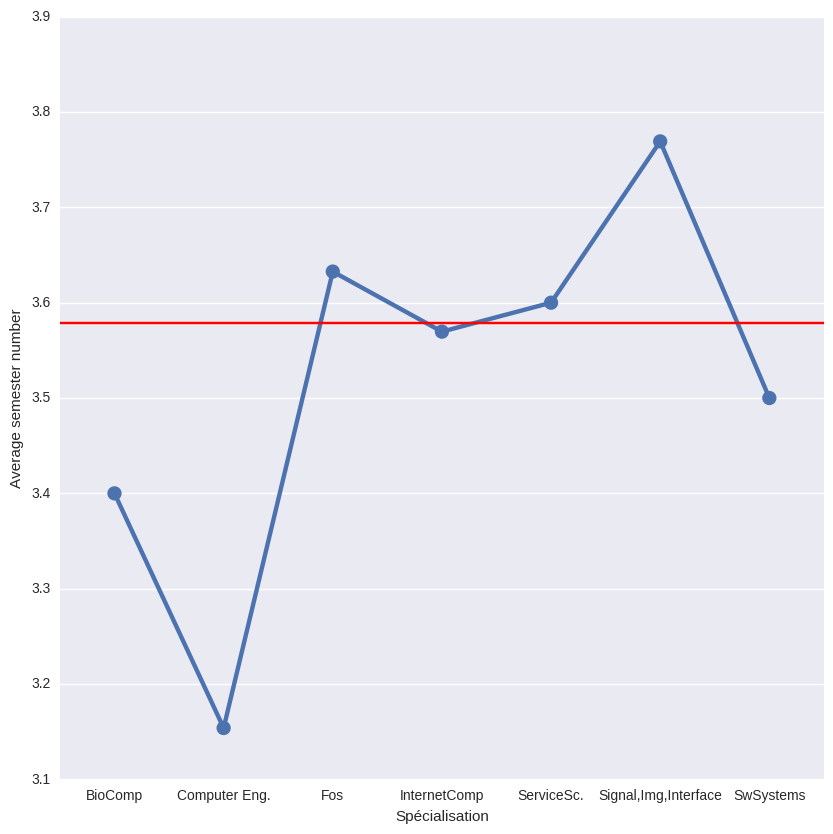

In [171]:
spe = pd.DataFrame({"Spécialisation": ["BioComp", "Computer Eng.", "Fos", "InternetComp", "ServiceSc.", "Signal,Img,Interface", "SwSystems"]})
master_spe_avg['Spécialisation'] = spe
g = sns.factorplot(x="Spécialisation", y="Average semester number", data=master_spe_avg, size=8.5)
axes = plt.gca()
axes.set_xlim([-0.5, 6.5])
plt.plot(np.linspace(-1,6.5,1000), [spe_avg]*1000, 'r')
plt.show()